# Imports

In [10]:
import os
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Image, display

# Helper functions

## Gaussian Plotter

This function takes a mean, standard deviation, and a color, it may optionally take an alpha and linestyle. Linestyle change from solid to dashed was used in this notebook to indicate the difference between the true and estimated distributions.

In [11]:
def plot_gaussian(mean, std, color, alpha=0.3, linestyle='solid'):
    # return a plot
    x = np.linspace(mean - 6*std, mean + 6*std, 100)
    y = norm.pdf(x, mean, std)
    # return the plot of the gaussian
    plt.plot(x, y, c=color,linestyle=linestyle)
    plt.fill_between(x, y, color=color, alpha=alpha)

## Data Plotter

Takes 1-D array of data and plots it on the number line. It may optionally take a color and a title. The color was used to distinguish which cluster the data belonged to, based on its current estimated probabilities.

In [12]:
def plot_data(data, colors = None, title = None):
    # return a plot
    plt.scatter(data, [0]*len(data), marker='o')
    plt.ylim([0, 1])
    if colors:
        plt.scatter(data, [0]*len(data), marker='o', c=colors)
    else:
        plt.scatter(data, [0]*len(data), marker='o', color='black')
    plt.xlabel("Value")
    if title:
        plt.title(title)
    else:
        plt.title("Data")

## Gaussian Probability

This function takes a mean, standard deviation, and a data point. It returns the probability of the data point being generated by the Gaussian distribution.

In [13]:
def gaussian_pdf(x, mean, std):
    return norm.pdf(x, mean, std)

# Motivation

This notebook's main motivation is to follow the example covered in class, with the addition of animations to provide a more intuitive understanding of soft clustering. The equations covered in class may be a bit difficult to understand, but the animations should help with that. Some resources that I found very helpful include the following links:

## Resources

### Bayes Refresher

- [3Blue1Brown's video on Baye's Theorem](https://www.youtube.com/watch?v=HZGCoVF3YvM)

### 1-D Gaussian Mixture Models

- [Victor Lavrenko: Gaussian mixture models](https://www.youtube.com/watch?v=REypj2sy_5U&list=PLBv09BD7ez_4e9LtmK626Evn1ion6ynrt)
  
## Personal Thoughts

I found that watching these videos and then going through the lecture slides/medium article helped me process the idea better. What made it click for me was the idea that GMM is like K-Means but the means are weighted with the probability of the data point belonging to that cluster. In the picture, below you can see that we are recalculating a mean, but with a "b" coefficient, which is a probability we calculate above. This is the main difference between K-Means and GMM, otherwise they are very similar.

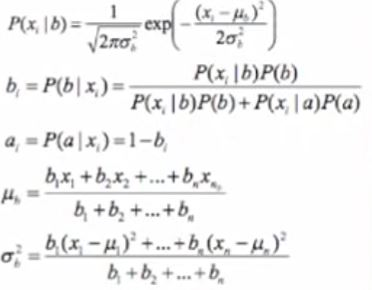


Medium Article: [Gaussian Mixture Models](https://medium.com/mlearning-ai/gmm-clustering-from-scratch-a8d06a47c77d)

# Implementation

## Step 1: Sampling from two Gaussian Distributions

In [14]:
# Define first gaussian
mean_1 = 5
std_1 = 1
s1 = np.random.normal(mean_1, std_1, 10).tolist()

# Define second gaussian
mean_2 = 10
std_2 = 1
s2 = np.random.normal(mean_2, std_2, 10).tolist()

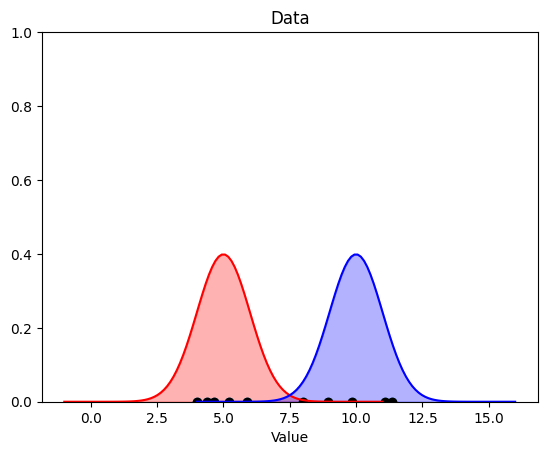

In [15]:
# Get the data 
data = []
for i in range(10):
    # flip coin
    coin_output = random.choice([0, 1])
    if coin_output == 0:
        p1 = s1.pop()
        data.append(p1)
    else:
        p2 = s2.pop()
        data.append(p2)

# Plot the data
plot_gaussian(mean_1, std_1, 'red')
plot_gaussian(mean_2, std_2, 'blue')
plot_data(data)
plt.show()

## Step 2: Initiating two random Gaussian Distributions

We will use this to build our estimates over-time.

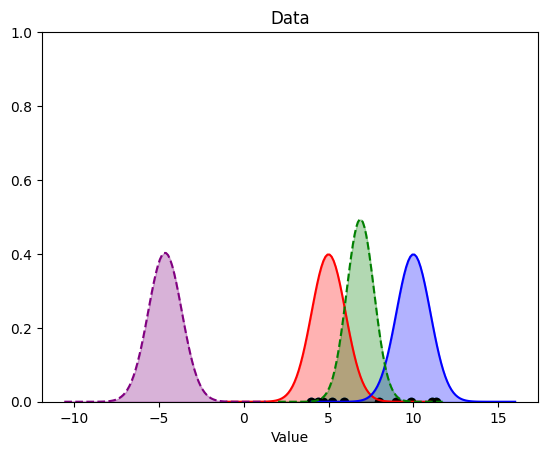

In [16]:
# Initialize k random gaussians
k = 2
random_colors = ['purple', 'green']
gaussians = {}
for i in range(k):
    mean = random.uniform(min(data) - 10*max(std_1, std_2), max(data) + 10*max(std_1, std_2))
    std = random.uniform(0.5, 2)
    gaussians[i] = [mean, std]

# Plot the initial gaussians
plot_gaussian(mean_1, std_1, 'red')
plot_gaussian(mean_2, std_2, 'blue')
for i in range(k):
    plot_gaussian(gaussians[i][0], gaussians[i][1], color=random_colors[i], linestyle='dashed')
plot_data(data)
plt.show()


# Step 3: Running the Expectation-Maximization Algorithm

This might be alot to take in but I hope the GIF illustrates exactly what is happening.

In [17]:
prob_s0_x = [] # P(S_0 | X_i)
prob_s1_x = [] # P(S_1 | X_i)
prob_x = [] # P(X_i)
threshold = 1e-12 # Convergence criterion
max_iter = 100 # To avoid infinite loop in case EM doesn't converge
iter_count = 0
log_likelihoods = []
images = []

# Calculate the x-axis limits
x_min = min(data) - 6*max(std_1, std_2)
x_max = max(data) + 6*max(std_1, std_2)
# Calculate the y-axis limits
y_max = 1

while iter_count < max_iter:
    # E-Step: Calculate the responsibilities
    prob_s0_x = []
    prob_s1_x = []
    prob_x = []
    log_likelihood = 0
    for point in data:
        prob_point_s0 = gaussian_pdf(point, gaussians[0][0], gaussians[0][1])
        prob_point_s1 = gaussian_pdf(point, gaussians[1][0], gaussians[1][1])
        total_prob_point = prob_point_s0 + prob_point_s1

        responsibility_s0 = prob_point_s0 / total_prob_point
        responsibility_s1 = prob_point_s1 / total_prob_point

        prob_s0_x.append(responsibility_s0)
        prob_s1_x.append(responsibility_s1)
        prob_x.append(total_prob_point)
        log_likelihood += np.log(total_prob_point)
    
    log_likelihoods.append(log_likelihood)

    # Convergence check
    if len(log_likelihoods) > 1 and np.abs(log_likelihood - log_likelihoods[-2]) < threshold:
            break

    # M-Step: Update Gaussian parameters
    for i, responsibilities in enumerate([prob_s0_x, prob_s1_x]):
        mean_num = sum([r * x for r, x in zip(responsibilities, data)])
        mean_denom = sum(responsibilities)
        
        variance_num = sum([r * (x - gaussians[i][0]) ** 2 for r, x in zip(responsibilities, data)])
        variance_denom = sum(responsibilities)
        
        gaussians[i][0] = mean_num / mean_denom
        gaussians[i][1] = np.sqrt(variance_num / variance_denom)

    # Store the plots for visualization
    plt.figure()
    plot_gaussian(mean_1, std_1, 'red')
    plot_gaussian(mean_2, std_2, 'blue')
    plt.xlim(x_min, x_max)  # Fixing x-axis limits
    plt.ylim(0, y_max)  
    plot_gaussian(gaussians[0][0], gaussians[0][1], color=random_colors[0], linestyle='dashed')
    plot_gaussian(gaussians[1][0], gaussians[1][1], color=random_colors[1], linestyle='dashed')
    plot_data(data, colors=[(1-p, 0, p) for p in prob_s0_x])
    plt.title(f"Iteration {iter_count + 1}")
    filename = f"iteration_{iter_count + 1}.png"
    plt.savefig(filename)
    images.append(imageio.imread(filename))
    plt.close()
    os.remove(filename)
    
    iter_count += 1

# Create a gif from the images
imageio.mimsave('em_algorithm.gif', images, duration=100, loop = 0)

C:\Users\kmfoc\AppData\Local\Temp\ipykernel_6992\3363363183.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


## Output Display

Will display in two ways: notebook cell/Markdown

### GMM GIF

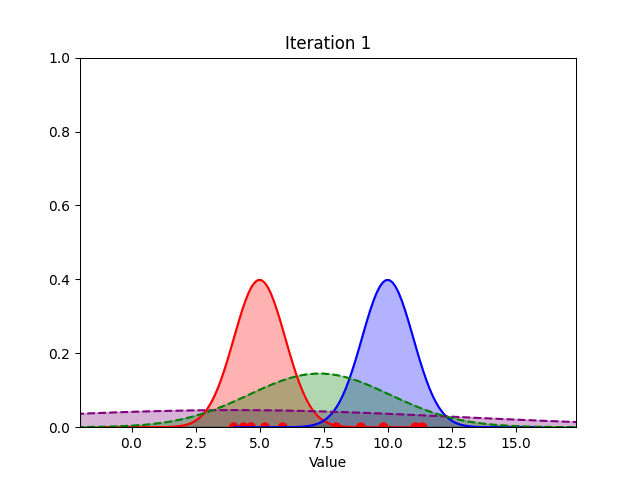

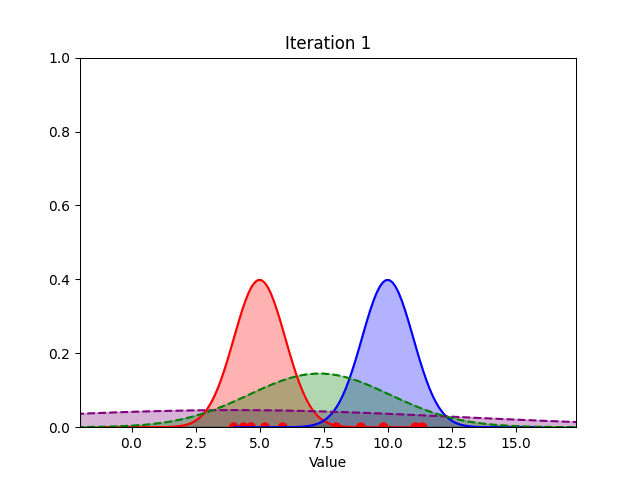

In [18]:
# Display the gif
display(Image(filename='em_algorithm.gif'))